In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! pip install -U accelerate
! pip install -U transformersa

ERROR: Could not find a version that satisfies the requirement transformersa (from versions: none)
ERROR: No matching distribution found for transformersa


In [3]:
# # Install dependencies
# !pip install ninja
# !apt-get install libopenblas-dev

# # Clone PyTorch repository
# !git clone --recursive https://github.com/pytorch/pytorch
# %cd pytorch

# # Install PyTorch with TORCH_USE_CUDA_DSA
# !TORCH_CUDA_ARCH_LIST="3.5+PTX;6.0+PTX;6.1+PTX;7.0+PTX" python setup.py install

In [4]:
# import os
# os.kill(os.getpid(), 9)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,1.374942,0.333333,0.166667,0.111111,0.333333
2,No log,1.427215,0.368148,0.239112,0.375249,0.368148
3,No log,1.318375,0.446667,0.383773,0.589744,0.446667
4,0.730000,1.142796,0.484444,0.441215,0.674639,0.484444


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


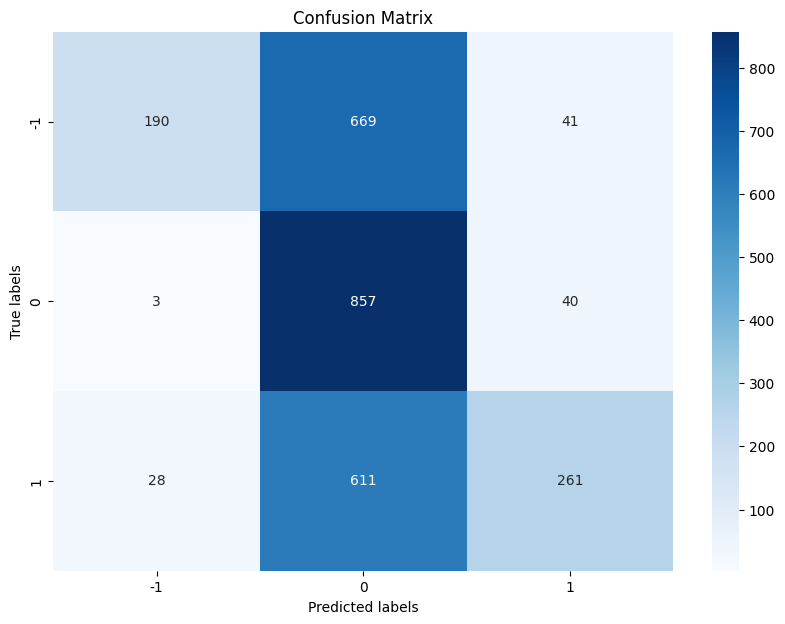

In [16]:
import numpy as np
import pandas as pd
import torch
import os
from torch.utils.data import Dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification, TrainingArguments, Trainer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Function to compute metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Function to plot confusion matrix
def plot_confusion_matrix(labels, preds, class_names):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Load the datasets
data_train = pd.read_excel('/content/drive/MyDrive/Thesis - Sentiment Analysis Dataset/1. experiment 2/1. Dataset/training_data.xlsx', sheet_name="Sheet1")
data_test = pd.read_excel('/content/drive/MyDrive/Thesis - Sentiment Analysis Dataset/1. experiment 2/1. Dataset/test_data.xlsx', sheet_name="Sheet1")

# Initialize and fit the label encoder
label_encoder = LabelEncoder()
data_train['label'] = label_encoder.fit_transform(data_train['label'])
data_test['label'] = label_encoder.transform(data_test['label'])

# Preprocessing the data
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

class SentimentDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.tokenizer = tokenizer
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        inputs = self.tokenizer(self.texts[idx], padding='max_length', truncation=True, max_length=128, return_tensors="pt")
        item = {key: val.squeeze() for key, val in inputs.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

# Convert to PyTorch datasets
train_dataset = SentimentDataset(tokenizer, data_train['text'].tolist(), data_train['label'].tolist())
test_dataset = SentimentDataset(tokenizer, data_test['text'].tolist(), data_test['label'].tolist())

# Initialize RoBERTa model
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(set(data_train['label'])))

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=4,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    learning_rate=3e-5,
    evaluation_strategy="epoch",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate the model
eval_result = trainer.evaluate()

# Plot confusion matrix
true_labels = np.array(test_dataset.labels)
predictions = trainer.predict(test_dataset).predictions.argmax(-1)
class_names = label_encoder.classes_
plot_confusion_matrix(true_labels, predictions, class_names)
